<a href="https://colab.research.google.com/github/LongfeiXue/EFIMM0139/blob/main/social_medial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyLDAvis
import pandas as pd
import tweepy
import nltk
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import time
import re
import matplotlib.pyplot as plt
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from scipy.special import softmax
from wordcloud import WordCloud
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.1 MB/s eta 0:00:00


In [ ]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


This section describes how to collect data.For the convenience of subsequent operations, the following dataset is directly used with the data saved here.So I commented out this code.

In [ ]:
# # Here is the code for how to get the data.
# #Some preparatory work
# consumer_key = 'Ep2J7nECBaLjsM6ENahyLlJRq'
# consumer_secret = 'VUXq0DRghZ3hLpq0z4q9GMVrk5zZTpQGIZWe5X3Pg2EHtL74wC'
# access_token = '1755216707080097792-0RTkgY62nDVjtuZnMYNUYl1D5ptmyp'
# access_token_secret = 'k4UfPIk7bPdy7yj62z4hCejm9kAIefhXtMQydMOxl3FdV'
# bearer_token = 'AAAAAAAAAAAAAAAAAAAAAJNltgEAAAAA%2B2h%2Fp0SRNqM5rZ41hoz2T8BHZtY%3DQJwcu9nFEHk7bNVLGO5ErSxdliNg7vUcEkfSZITIOtQrxDi6mj'
# # creat a new client
# client = tweepy.Client(bearer_token=bearer_token)
# username = 'tesla'
# user = client.get_user(username=username, user_fields=['id', 'name', 'username', 'created_at', 'description'])

# # Print some details
# print(f"User ID: {user.data.id}")
# print(f"Name: {user.data.name}")
# print(f"Username: {user.data.username}")
# print(f"Account Created At: {user.data.created_at}")
# print(f"Description: {user.data.description}")
# # Get tesla's top 100 tweets on Twitter
# tweets_tesla = client.get_users_tweets(id=user.data.id, max_results=100, tweet_fields=['id', 'text', 'created_at', 'public_metrics'])
# # get information about tesla tweet
# tweets_data = []
# for tweet in tweets_tesla.data:
#     tweets_data.append({
#         'Tweet ID': tweet.id,
#         'Text': tweet.text,
#         'Created At': tweet.created_at,
#         'Like Count': tweet.public_metrics['like_count'],
#         'Retweet Count': tweet.public_metrics['retweet_count'],
#         'Reply Count': tweet.public_metrics['reply_count'],
#         'Quote Count': tweet.public_metrics['quote_count']
#     })
# df = pd.DataFrame(tweets_data)
# # Conversion time format
# df['Created At'] = df['Created At'].dt.tz_localize(None)
# # save as excel
# df.to_excel('tweets_tesla.xlsx', index=False)
# # Get 200 comments per tesla's top 40 tweets on Twitter
# if user.data:
#     user_id = user.data.id
#     tweets = client.get_users_tweets(id=user_id, max_results=20, tweet_fields=['id'])
#     if tweets.data:
#         # used to save comments
#         all_replies = []

#         # Get up to 200 comments per tweet
#         for tweet in tweets_tesla.data:
#             tweet_id = tweet.id
#             # Search for tweets that reply to that tweet
#             query = f'conversation_id:{tweet_id} to:{username}'
#             # Use Paginator to traverse the comments
#             replies = []
#             # limit=2 ensure a maximum of 200 comments
#             for response in tweepy.Paginator(client.search_recent_tweets, query=query, max_results=100, limit=2):
#                 if response.data:
#                     replies.extend(response.data)
#             # Add comments to the overall list
#             for reply in replies:
#                 all_replies.append({
#                     'Tweet ID': tweet_id,
#                     'Reply ID': reply.id,
#                     'Text': reply.text,
#                     'Created At': reply.created_at,
#                 })
#         # Convert to a DataFrame
#         import pandas as pd
#         if all_replies:
#             replies_df = pd.DataFrame(all_replies)
#             print(replies_df)
#             # Save as excel
#             replies_df.to_excel('tesla_replies.xlsx', index=False)
#         else:
#             print("No review found")
#     else:
#         print("No tweets found")

# # Collect 2,000 tweets about tesla

# query = 'tesla -is:retweet'
# # Define the required tweet segment
# tweet_fields = ['id', 'text', 'author_id', 'created_at', 'public_metrics']

# # save
# tweets_data = []

# # Use the pager to collect tweets
# for tweet in tweepy.Paginator(method=client.search_recent_tweets,
#                               query=query,
#                               tweet_fields=tweet_fields,
#                               max_results=100).flatten(limit=2000):
#     tweets_data.append({
#         'Tweet ID': tweet.id,
#         'Text': tweet.text,
#         'Author ID': tweet.author_id,
#         'Created At': tweet.created_at,
#         'Likes': tweet.public_metrics['like_count'],
#         'Retweets': tweet.public_metrics['retweet_count'],
#         'Replies': tweet.public_metrics['reply_count']
#     })

# # convert to DataFrame
# tweets = pd.DataFrame(tweets_data)
# print(tweets)
# tweets['Created At'] = tweets['Created At'].dt.tz_localize(None)
# tweets.to_excel('tweets.xlsx', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Data** **cleaning**

In [ ]:
#Read 100 tweets from tesla and count them
tweets_tesla = pd.read_excel('tweets_tesla.xlsx')
print ('The length of the dataset is %s'%len(tweets_tesla))
print ('The begining date of the dataset is %s'%(str(min(tweets_tesla['Created At']))))
print ('The ending date of the dataset is %s'%(str(max(tweets_tesla['Created At']))))
print ("There are %s columns in this dataset"%(len(tweets_tesla.columns.values)))
print(tweets_tesla.columns.values)

#Read replies about tesla and count them
tweets = pd.read_excel('tweets.xlsx')
print ('The length of the dataset is %s'%len(tweets))
print ('The begining date of the dataset is %s'%(str(min(tweets['Created At']))))
print ('The ending date of the dataset is %s'%(str(max(tweets['Created At']))))
print ("There are %s columns in this dataset"%(len(tweets.columns.values)))
print(tweets.columns.values)
#Read replies about tesla's tweets and count them
tesla_replies = pd.read_excel('tesla_replies.xlsx')
print ('The length of the dataset is %s'%len(tesla_replies))
print ('The begining date of the dataset is %s'%(str(min(tesla_replies['Created At']))))
print ('The ending date of the dataset is %s'%(str(max(tesla_replies['Created At']))))
print ("There are %s columns in this dataset"%(len(tesla_replies.columns.values)))
print(tesla_replies.columns.values)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The length of the dataset is 98
The begining date of the dataset is 2024-02-29 17:10:27
The ending date of the dataset is 2024-05-02 13:47:54
There are 7 columns in this dataset
['Tweet ID' 'Text' 'Created At' 'Like Count' 'Retweet Count' 'Reply Count'
 'Quote Count']
The length of the dataset is 2000
The begining date of the dataset is 2024-05-02 13:54:48
The ending date of the dataset is 2024-05-02 14:59:49
There are 7 columns in this dataset
['Tweet ID' 'Text' 'Author ID' 'Created At' 'Likes' 'Retweets' 'Replies']
The length of the dataset is 791
The begining date of the dataset is nan
The ending date of the dataset is nan
There are 4 columns in this dataset
['Tweet ID' 'Reply ID' 'Text' 'Created At']


In [ ]:
# Find null value information
null_counts = tweets_tesla.isna().sum()
print(null_counts)
print('**')
null_counts = tweets.isna().sum()
print(null_counts)
print('**')
null_counts = tesla_replies.isna().sum()
print(null_counts)
print('**')


Tweet ID         0
Text             0
Created At       0
Like Count       0
Retweet Count    0
Reply Count      0
Quote Count      0
dtype: int64
**
Tweet ID      0
Text          0
Author ID     0
Created At    0
Likes         0
Retweets      0
Replies       0
dtype: int64
**
Tweet ID        0
Reply ID        0
Text            0
Created At    791
dtype: int64
**


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# drop null value
tesla_replies.drop(columns=['Created At'], inplace=True)

tweets_tesla.drop_duplicates(inplace=True)
tweets.drop_duplicates(inplace=True)
tesla_replies.drop_duplicates(inplace=True)
print ('The length of the dataset is %s'%len(tweets_tesla))
print ('The length of the dataset is %s'%len(tweets))
print ('The length of the dataset is %s'%len(tesla_replies))

The length of the dataset is 98
The length of the dataset is 2000
The length of the dataset is 791


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# processing text
col_from_df1 = tweets['Text']
col_from_df2 = tesla_replies['Text']
text_df = pd.DataFrame(pd.concat([col_from_df1, col_from_df2], axis=0, ignore_index=True))
text_df.columns = ['Text']
text_df.drop_duplicates(inplace=True)
text_df=text_df.reset_index(inplace=False)
text_df.drop(columns=['index'], inplace=True)
text_df


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Text
0,@TeslaBoomerMama @MartinViecha @Tesla @elonmus...
1,@xnonprofits @TESLA_CREADOR 😂😂😂😂😂
2,@katrosenfield @qveew Someone will think it’s ...
3,@EvasTeslaSPlaid @Tesla @elonmusk Great car👍♥️
4,TESLA RED OR BLACK!? https://t.co/84eTPloQ5e
...,...
2623,@Tesla Super ugly seats😒
2624,@Tesla @elonmusk Meow-mentum is building! 🐾 Di...
2625,@Tesla @AiDigitalMktg I asked service and they...
2626,@Tesla We pioneers of the world declare our su...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1500x800 with 0 Axes>

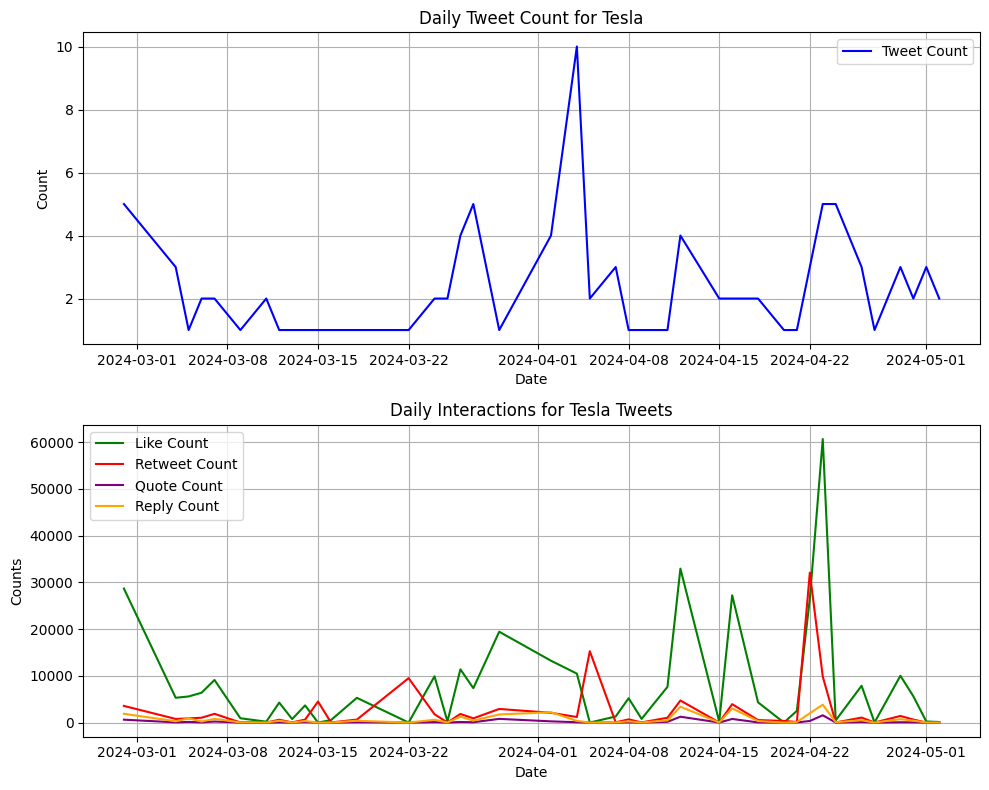

In [ ]:
# descriptive analysis
# Convert date format
tweets_tesla['date'] = tweets_tesla['Created At'].dt.date
tweets_tesla['date'] = pd.to_datetime(tweets_tesla['date'])

grouped_data = tweets_tesla.groupby('date').agg({
    'Tweet ID': 'count',
    'Like Count': 'sum',
    'Retweet Count': 'sum',
    'Quote Count': 'sum',
    'Reply Count': 'sum'
})
plt.figure(figsize=[15,8])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# First chart: Number of tweets
ax1.plot(grouped_data.index, grouped_data['Tweet ID'], label='Tweet Count', color='blue')
ax1.set_title('Daily Tweet Count for Tesla')
ax1.set_xlabel('Date')
ax1.set_ylabel('Count')
ax1.legend()
ax1.grid(True)

# Second chart: Other statistics
ax2.plot(grouped_data.index, grouped_data['Like Count'], label='Like Count', color='green')
ax2.plot(grouped_data.index, grouped_data['Retweet Count'], label='Retweet Count', color='red')
ax2.plot(grouped_data.index, grouped_data['Quote Count'], label='Quote Count', color='purple')
ax2.plot(grouped_data.index, grouped_data['Reply Count'], label='Reply Count', color='orange')
ax2.set_title('Daily Interactions for Tesla Tweets')
ax2.set_xlabel('Date')
ax2.set_ylabel('Counts')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
descriptive_stats = tweets_tesla[['Like Count','Retweet Count','Reply Count','Quote Count']].describe()
print(descriptive_stats)

         Like Count  Retweet Count  Reply Count  Quote Count
count     98.000000      98.000000    98.000000    98.000000
mean    3429.693878    1086.234694   274.500000    71.571429
std     5423.132135    3261.715565   492.412539   171.736852
min        0.000000       1.000000     0.000000     0.000000
25%       92.500000       6.000000     6.000000     0.000000
50%      739.500000      60.500000    20.500000     2.000000
75%     5145.750000     989.250000   321.250000    62.000000
max    26751.000000   27826.000000  2081.000000   846.000000


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Sentiment analysis
# Data Preprocessing Functions

# Set stopwords and initialize the WordNet Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
# Function to preprocess and lemmatize text
def preprocess_and_lemmatize(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords and lemmatize
    lemmatized_words = [lemmatizer.lemmatize(word, pos="v") for word in words if word not in stop_words]
    # Join words back into a string
    return ' '.join(lemmatized_words)
text_df['Text']=text_df['Text'].str.replace('[^a-zA-Z\s]', '', regex=True)
text_df['Text'] = [preprocess_and_lemmatize(headline) for headline in tqdm(text_df['Text'])]
text_df['word_count'] = text_df['Text'].str.split().str.len()
# lemmatization
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
text_df['Text'] = text_df['Text'].apply(lambda x: lemmatizer_on_text(x))
# Filter out lines with 8 or more words
text_df = text_df[text_df['word_count'] >= 8]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:20: DeprecationWarning: invalid escape sequence '\s'
<>:20: DeprecationWarning: invalid escape sequence '\s'
<ipython-input-208-fedda640fabe>:20: DeprecationWarning: invalid escape sequence '\s'
  text_df['Text']=text_df['Text'].str.replace('[^a-zA-Z\s]', '', regex=True)
100%|██████████| 2628/2628 [00:02<00:00, 1181.95it/s]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Bag of Words Analysis on a sample of the dataset:


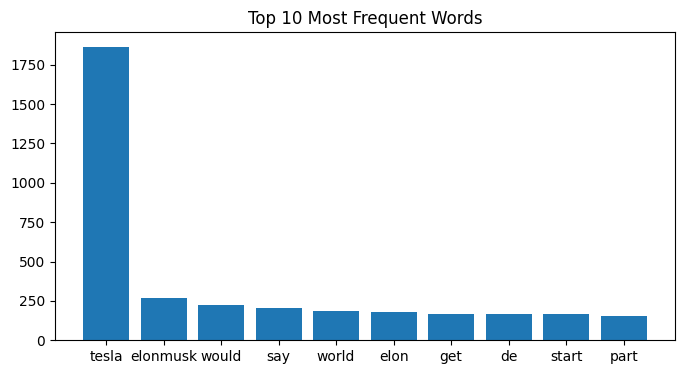


TF-IDF Analysis on the same sample of the dataset:


<Figure size 800x400 with 0 Axes>

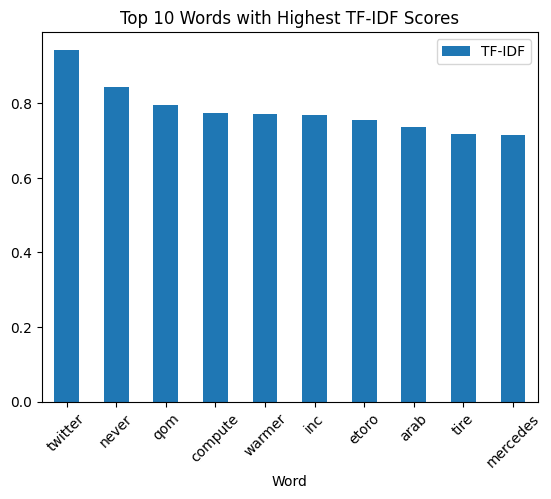

In [ ]:
# Bag of Words Analysis
def bag_of_words_analysis(texts):
    """
    This function performs Bag of Words analysis and plots the top 10 frequent words.
    """
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split())

    most_common = word_counts.most_common(10)
    words, counts = zip(*most_common)

    # Plotting
    plt.figure(figsize=(8,4))
    plt.bar(words, counts)
    plt.title("Top 10 Most Frequent Words")
    plt.show()

    return most_common

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# TF-IDF Analysis
def tf_idf_analysis(texts):
    """
    This function performs TF-IDF analysis and plots the top 10 words with highest TF-IDF scores.
    """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Gets the maximum TF-IDF score per word across all documents
    # Take the maximum value by column
    max_tfidf_scores = tfidf_matrix.max(axis=0).toarray().flatten()
    sorted_indices = np.argsort(max_tfidf_scores)[::-1]

    # Extract the top 10 words with high scores and their scores
    top_n_indices = sorted_indices[:10]
    top_n_words = feature_names[top_n_indices]
    top_n_scores = max_tfidf_scores[top_n_indices]

    # plot
    plt.figure(figsize=(8,4))
    df = pd.DataFrame({'Word': top_n_words, 'TF-IDF': top_n_scores})
    df.plot.bar(x='Word', y='TF-IDF', rot=45, title="Top 10 Words with Highest TF-IDF Scores")
    plt.show()

    return top_n_words

print("Bag of Words Analysis on a sample of the dataset:")
bow_results = bag_of_words_analysis(text_df['Text'])

# Perform TF-IDF Analysis on the same sample
print("\nTF-IDF Analysis on the same sample of the dataset:")
tfidf_results = tf_idf_analysis(text_df['Text'])


In [ ]:
# Load pre-trained model and tokenizer
model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

def sentiment_score(review_text):
    # Encode the text
    encoded_review = tokenizer.encode_plus(
        review_text,
        max_length=512,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    # Forward pass, get logits
    input_ids = encoded_review['input_ids'].to('cpu')
    attention_mask = encoded_review['attention_mask'].to('cpu')

    with torch.no_grad():
        output = model(input_ids, attention_mask)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)

    return scores
text_df['sentiment_scores'] = text_df['Text'].apply(sentiment_score)

text_df[['negative', 'neutral', 'positive']] = pd.DataFrame(text_df['sentiment_scores'].tolist(), index=text_df.index)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the bat

KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sentiment
neutral     1296
positive     242
negative     241
Name: count, dtype: int64

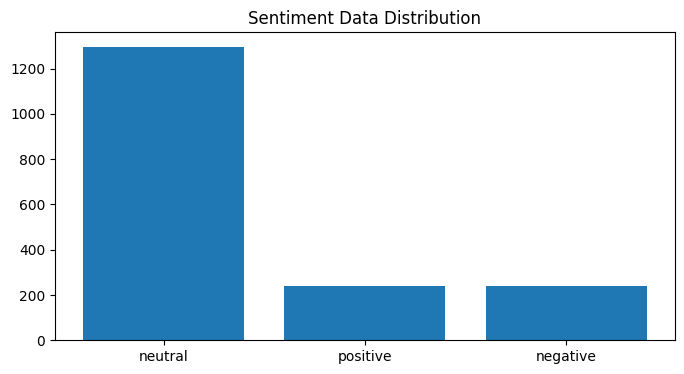

In [ ]:
# word cloud
text_df = pd.read_excel('text.xlsx')
text_df['sentiment'] = text_df[['negative', 'neutral', 'positive']].idxmax(axis=1)
text_df.to_excel('text.xlsx', index=False)
val_count = text_df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")
val_count

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


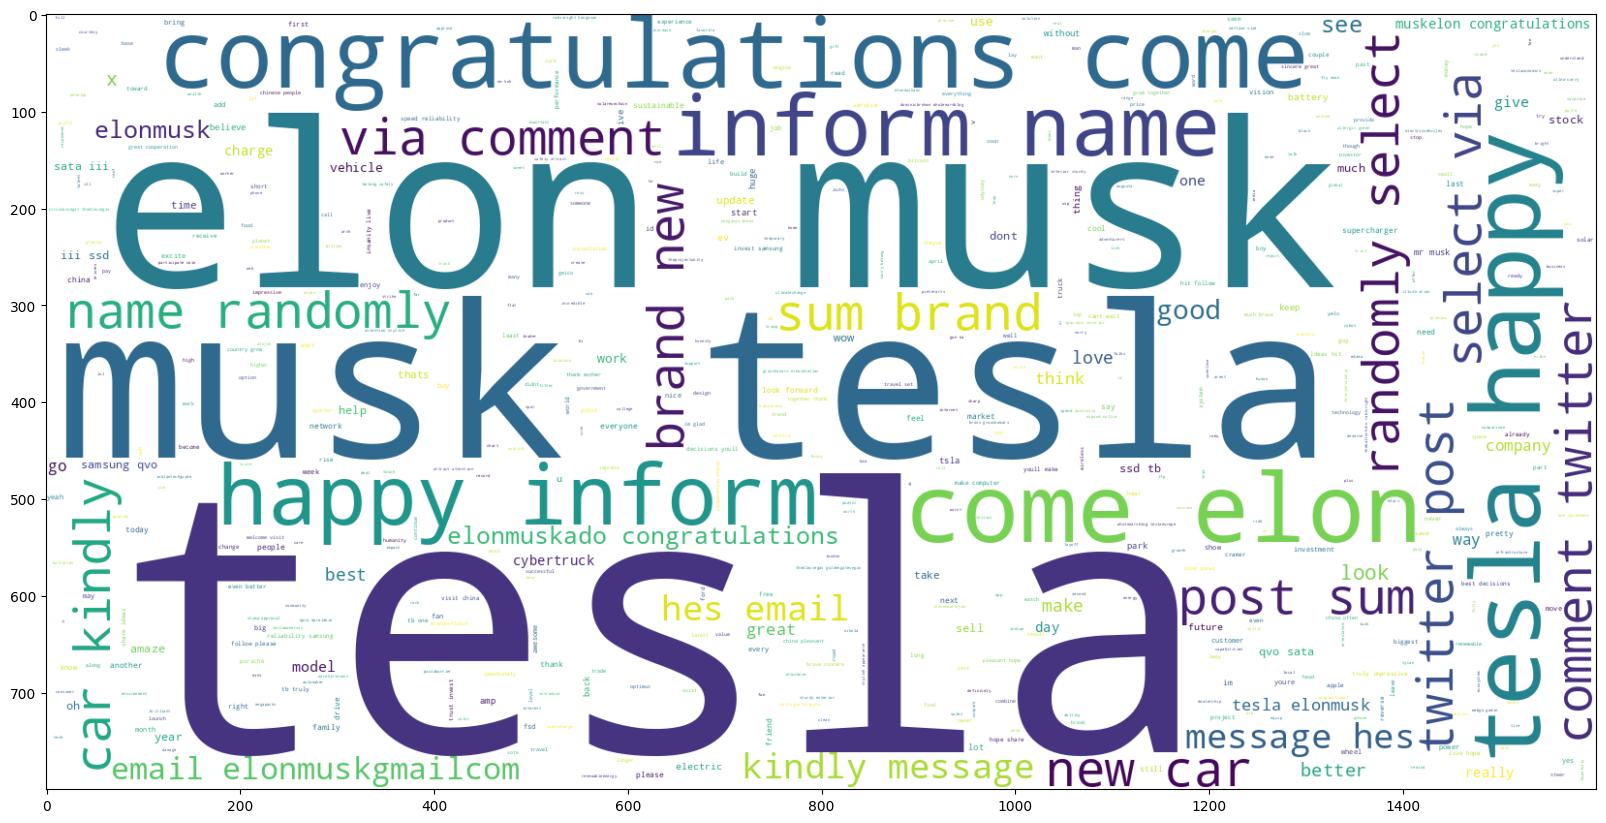

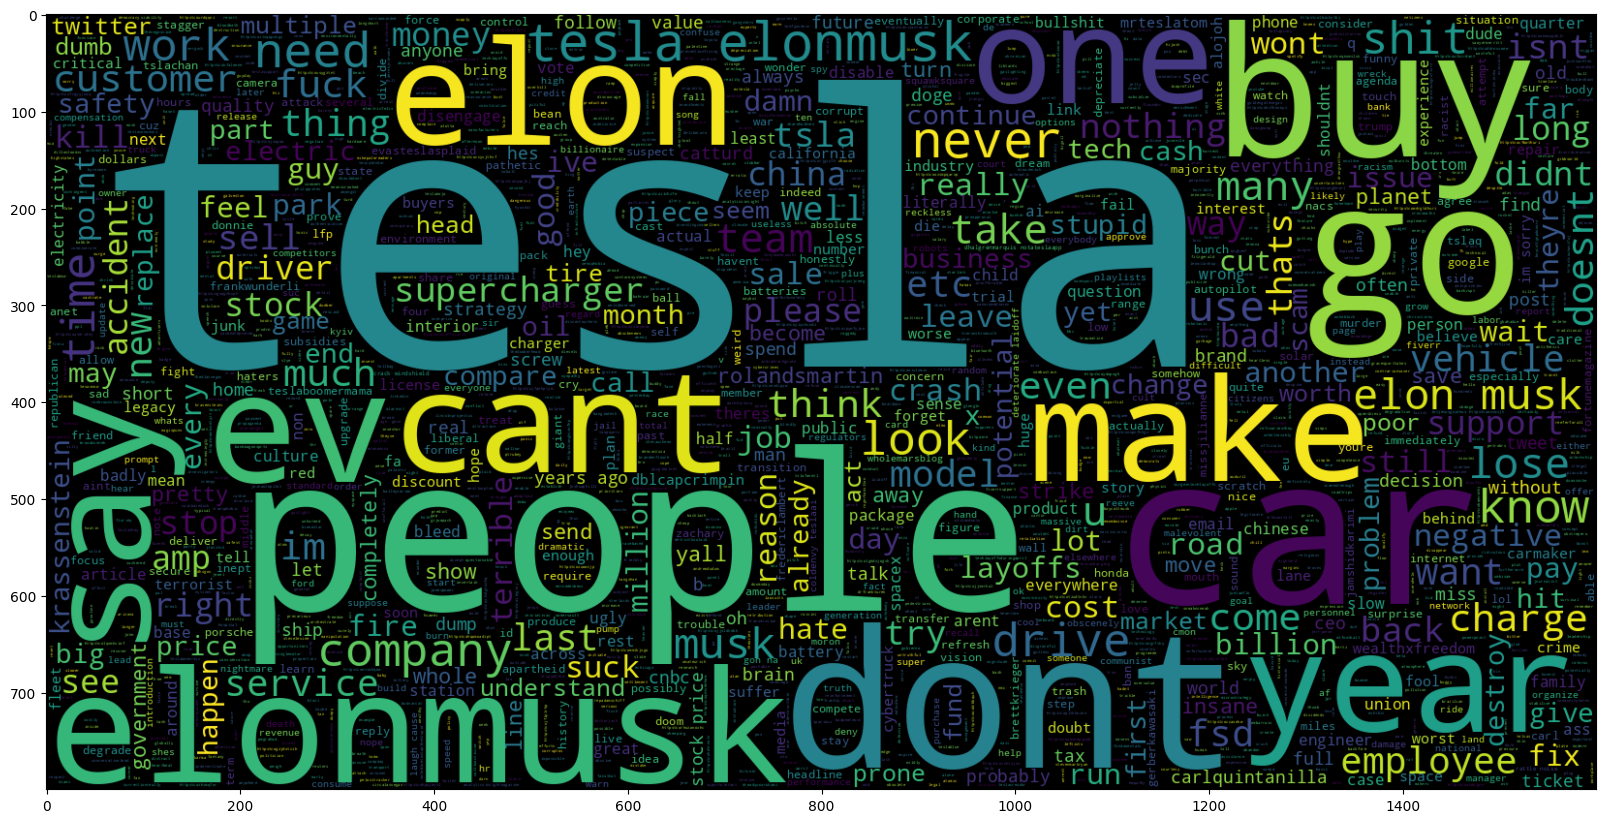

In [ ]:
# word cloud
plt.figure(figsize = (20,20))
wc = WordCloud(background_color = 'white',max_words = 2000 , width = 1600 , height = 800).generate(" ".join(text_df[text_df.sentiment == 'positive'].Text))
plt.imshow(wc , interpolation = 'bilinear')
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(text_df[text_df.sentiment == 'negative'].Text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
# LDA topic model
text_copy = text_df.copy(deep=False)
stop_words = set(['the','a'])
def generate_tokens(tweet):
    words=[]
    for word in tweet.split(' '):
    # using the if condition because we introduced extra spaces during text cleaning
        if word != '' and word not in stop_words:
        # if word!='':
           words.append(word)
    return words
text_copy['tokens']=text_copy.Text.apply(generate_tokens)
def create_dictionary(words):
    return corpora.Dictionary(words)
id2word=create_dictionary(text_copy['tokens'])

def create_document_matrix(tokens,id2word):
    corpus = []
    for text in tokens:
        corpus.append(id2word.doc2bow(text))
    return corpus
#passing the dataframe column having tokens and dictionary
corpus=create_document_matrix(text_copy['tokens'],id2word)
pyLDAvis.enable_notebook()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=100, )
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.026955  0.049154       1        1  15.758595
3      0.059671  0.144608       2        1  13.721499
6     -0.075962 -0.100309       3        1  12.893459
2     -0.034897  0.134062       4        1  12.203623
9      0.005599 -0.146251       5        1   9.488454
1     -0.140550  0.063352       6        1   9.328646
4      0.016444 -0.072540       7        1   8.652670
0     -0.140431 -0.033453       8        1   7.445237
8      0.135576  0.044890       9        1   5.607394
5      0.147595 -0.083514      10        1   4.900424, topic_info=              Term        Freq       Total Category  logprob  loglift
97      mentorship  110.000000  110.000000  Default  30.0000  30.0000
94              hi  116.000000  116.000000  Default  29.0000  29.0000
102         scheme  110.000000  110.000000  Default  28.0000  28.0000
96       impactful  110.000000  110.000000  Default  27.0000  27.0000
92       followers  111.000000  111.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
273           work    3.677380   44.805595  Topic10  -6.0785   0.5157
313   teslacreador    3.597951   57.238623  Topic10  -6.1004   0.2490
1119          back    3.475357   37.156532  Topic10  -6.1351   0.6464
1         elonmusk    3.810424  208.985477  Topic10  -6.0430  -0.9887
494             im    3.517590   50.982550  Topic10  -6.1230   0.3421

[783 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
5664     10  0.450017     adowarki
2710      1  0.894629  adventurers
399       7  0.326939    affiliate
399       8  0.653878    affiliate
6182      9  0.861452   aggressive
...     ...       ...          ...
815       2  0.304112        youll
815       5  0.202741        youll
815       7  0.101371        youll
815      10  0.304112        youll
3457     10  0.673004       zyklus

[1858 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 7, 3, 10, 2, 5, 1, 9, 6])